In [1]:
#pip install quantecon

In [2]:
import numpy as np
import math
from scipy.optimize import fsolve
from quantecon.markov.approximation import tauchen
import matplotlib.pyplot as plt
from scipy import interpolate
from numba import jit

In [61]:
# Define parameter values
θ = .21
ν = .64
δ = .1
β = .96
φ = .5
ρ = .9
σ = .02
N_rep = .6   # assume steady state labor supply from rep. household
tol = 1e-6
nϵ = 11
ϵ = tauchen(ρ,σ,0,3,nϵ)

In [5]:
'''
------------------------------------------------------------------------
Functions for steady state
------------------------------------------------------------------------
'''

# Firm labor demand given w and k
n_star = lambda ν,θ,ϵ,w,k: (w/(math.exp(ϵ)*ν*k**θ))**(1/(ν-1)) if k != 0  else 0
# Derivative of firm profit wrt k
π_k = lambda ν,θ,ϵ,w,k: θ*math.exp(ϵ)*k**(θ-1)*(w/(ν*math.exp(ϵ)*k**θ))**(ν/(ν-1))
# Derivative of value function V wrt k
V_k = lambda ν,θ,δ,φ,ϵ,w,k: π_k(ν,θ,ϵ,w,k) - φ/2*δ**2+(φ-1)*δ+1

# Left hand side of firm FOC
def foc(k,w,parameters):
    β,ν,θ,δ,φ,ϵ = parameters
    foc_lhs = -1-φ*δ + β*V_k(ν,θ,δ,φ,ϵ,w,k)
    return foc_lhs

# Solve for steady state capital given w
def get_Kss(w,parameters):
    kss = fsolve(foc,.1,args=(w,parameters))
    return kss

# Solve the steady state capital and w
def excess_labor_supply(w,parameters):
    β,ν,θ,δ,φ,N_rep = parameters
    k = get_Kss(w,[β,ν,θ,δ,φ,0])
    n = n_star(ν,θ,0,w,k)
    n_excess = N_rep - n
    return n_excess               

In [52]:
'''
------------------------------------------------------------------------
Functions for solving policy functions
------------------------------------------------------------------------
'''
# Value function iteration based on grid
def VFI(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    inv_friction = lambda φ,i,k: φ/2*(i/k)**2 *k if k != 0 else 0
    
    # Initialized some values
    nϵ,nk = len(ϵ.state_values),len(k_grid)
    V = np.zeros((nϵ*nk,1))
    max_diff = np.inf
    niter = 1
    
    # Iterate until convergence
    while max_diff > tol:
        # A vector for expected continuation value. Each capital value stands for k'
        ev = np.zeros((nϵ*nk,1))
        for ikp in range(nk):
            idxp = np.arange(ikp,nϵ*nk+ikp,nk)
            for iϵ in range(nϵ):            
                idx = iϵ*nk + ikp                 
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                
        tempV = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
        
        # Only solve maximization 2 out of 5 times to speed up the code
        if niter % 5 == 1 or niter % 5 == 2:
            gk = np.zeros((nϵ*nk,1),dtype='int')    # policy function for k'
        ge = np.ones((nϵ*nk,1))                     # policy function for exit
        
        # Iterate over states today
        for ik,k in enumerate(k_grid):            
            for iϵ,ϵ_curr in enumerate(ϵ.state_values):            
                idx = iϵ*nk + ik 
                
                # Only solve maximization 2 out of 5 times to speed up the code
                if niter % 5 == 1 or niter % 5 == 2:
                    vv = (1-δ)*k 

                    # Find the k' that maximizes firm's value
                    for ikp,kp in enumerate(k_grid):
                        idxp = iϵ*nk + ikp
                        investment = kp - (1-δ)*k
                        v_tilde = π(ν,θ,ϵ_curr,w,k) - investment - inv_friction(φ,investment,k) + β*ev[idxp]

                        if v_tilde - cf > (1-δ)*k:
                            if v_tilde > vv:
                                vv = v_tilde
                                tempV[idx] = v_tilde
                                gk[idx] = ikp
                                ge[idx] = 0
                else:
                    investment = k_grid[gk[idx]] - (1-δ)*k
                    idxp = iϵ*nk + gk[idx]
                    v_tilde = π(ν,θ,ϵ_curr,w,k) - investment - inv_friction(φ,investment,k) + β*ev[idxp]
                    if v_tilde - cf > (1-δ)*k:
                        tempV[idx] = v_tilde
                        ge[idx] = 0
                        
        max_diff = max(np.abs(V-tempV))
        V = tempV.copy()
        if niter == 1 or niter % 50 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk,ge

In [62]:
# Solve for representative agent steady state
w = 1
parameters = [β,ν,θ,δ,φ,N_rep]
wss = fsolve(excess_labor_supply,.25,args=parameters)
kss = get_Kss(wss,[β,ν,θ,δ,φ,0])

nk = 50
k_grid = np.linspace([0],[5],nk)
parameters = [ν,θ,δ,φ,tol]

In [65]:
# Solve for incumbent firm's decision rules
cf = .01
V1,gk1_idx,ge1 = VFI(cf,wss,k_grid,parameters,ϵ)
gk1 = k_grid[gk1_idx.reshape(nϵ*nk,1)].reshape(nϵ*nk,1)

Iteration 1: max diff = 4.5000000
Iteration 50: max diff = 0.0167160
Iteration 100: max diff = 0.0021582
Iteration 150: max diff = 0.0002803
Iteration 200: max diff = 0.0000364
Iteration 250: max diff = 0.0000047


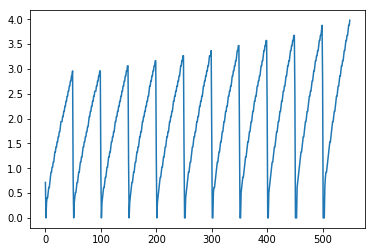

In [71]:
plt.plot(gk1)

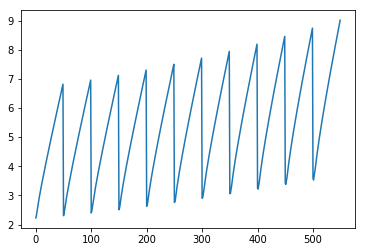

In [59]:
plt.plot(V1)

In [97]:
# Find the value for k this period using the Euler equation
def euler_solvek(kp,ikp,gk,w,ν,θ,β,φ,δ,ϵ,iϵ):
    E_Vk = 0
    nϵ = len(ϵ.state_values)
    nk = np.int(len(gk) / nϵ)
    
    for iϵp,ϵp in enumerate(ϵ.state_values):
        idxp = iϵp*nk + ikp 
        E_Vk = E_Vk + ϵ.P[iϵ,iϵp]*(π_k(ν,θ,ϵp,w,kp)+(1-δ)-φ/2*((gk[idxp]/kp-(1-δ))**2-2*gk[idxp]/kp*(gk[idxp]/kp-(1-δ))))
       
    if kp != 0:
        k = kp / (1/φ * (β*E_Vk-1) + 1-δ)
    else:
        k = 0
    return k

# Endogenous grid method for incumbent firm's decision rules (doesn't work very well)
def EGM(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    v_kp0 = lambda k,ν,θ,δ,φ,β,ϵ_curr,w,ev0,v0: π(ν,θ,ϵ_curr,w,k)+(1-δ)*k-φ/2*(1-δ)**2*k+β*ev0 - v0
    
    nϵ,nk = len(ϵ.state_values),len(k_grid)    
    max_diff = np.inf
    niter = 1
    
    # Guess value functions
    V_e = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    V_tilde = V_e + np.ones((nϵ,1)).dot(np.linspace(.1,.2,nk).reshape(1,nk)).reshape(nϵ*nk,1)
    V = np.maximum(V_tilde-cf,V_e)

    # Guess a policy function of k' defined on the original grid
    gk = np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    
    while max_diff > tol:

        ev = np.zeros((nϵ*nk,1))
        for iϵ in range(nϵ):
            for ik in range(nk):
                idx = iϵ*nk + ik 
                idxp = np.arange(ik,nϵ*nk+ik,nk)
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                        
        k_end,V_tilde_end,V_tilde_new,ge = np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1)),np.ones((nϵ*nk,1))
        
        for iϵ, ϵ_curr in enumerate(ϵ.state_values):
            grid_range = np.arange(iϵ*nk,iϵ*nk+nk,1)
            ev_interp = interpolate.interp1d(k_grid.reshape(nk,),ev[grid_range].reshape(nk,),fill_value='extrapolate')
            
            # Iterate over k'
            ik_cutoff = 0
            for ikp,kp in enumerate(k_grid):
                idxp = iϵ*nk + ikp 
                k = euler_solvek(kp,ikp,gk,w,ν,θ,β,φ,δ,ϵ,iϵ)                                       
                k_end[idxp] = k
                
                if k != 0:
                    V_tilde_end[idxp] = π(ν,θ,ϵ_curr,w,k) - (kp-(1-δ)*k) - φ/2*(kp/k-(1-δ))**2 *k + β*ev_interp(k)
                else:
                    V_tilde_end[idxp] = - (kp-(1-δ)*k) + β*ev_interp(k)
                    
                if V_tilde_end[idxp] - cf < (1-δ)*k:
                    ik_cutoff = ikp
            
            V_tilde_end_interp = interpolate.interp1d(k_end[grid_range].reshape(nk,),V_tilde_end[grid_range].reshape(nk,),fill_value='extrapolate',assume_sorted=False)
            gk_interp = interpolate.interp1d(k_end[grid_range].reshape(nk,),k_grid.reshape(nk,),fill_value='extrapolate',assume_sorted=False)
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik                
                V_tilde_new[idx] = V_tilde_end_interp(k)
                if V_tilde_new[idx] - cf >= (1-δ)*k:
                    ge[idx] = 0
                
                if ik <= ik_cutoff:
                    gk[idx] = 0                    
                else:
                    gk[idx] = gk_interp(k)   
                gk[idx] = gk_interp(k)
        
        V_new = np.maximum(V_tilde_new-cf,V_e)
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
#         V_new = V_tilde_new.copy()
#         max_diff = max(np.abs(V_new-V))
#         V = V_new.copy()
        if niter == 1 or niter % 50 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1

    return V,gk,ge

In [93]:
cf = .01
parameters = ν,θ,δ,φ,tol
V2,gk2,ge2 = EGM(cf,wss,k_grid,parameters,ϵ)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Iteration 1: max diff = 0.8417027
Iteration 50: max diff = 0.2125150
Iteration 100: max diff = 0.0275735
Iteration 150: max diff = 0.0035814
Iteration 200: max diff = 0.0004652
Iteration 250: max diff = 0.0000604
Iteration 300: max diff = 0.0000078
Iteration 350: max diff = 0.0000010


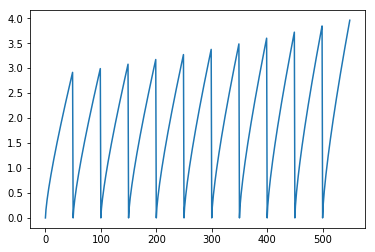

In [94]:
plt.plot(gk2)

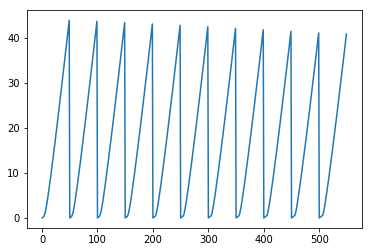

In [95]:
plt.plot(V2)

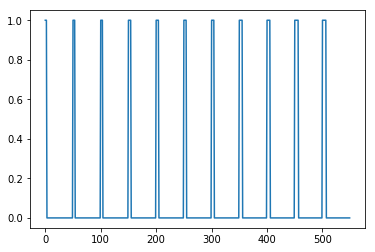

In [96]:
plt.plot(ge2)